In [56]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as ophys_formatting
import brain_observatory_utilities.utilities.general_utilities as utilities

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache
import pickle
pd.set_option('display.max_columns', 500)
from scipy.ndimage import gaussian_filter1d

In [38]:
datafolder = "D:\\neuromatch2024\\datasets\\project\\Allen\\temp\\combined_files\\"
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=datafolder)

ophys_session_id = 854060305
ophys_experiment_ids = [854759890, 854759894, 854759896, 854759898]

# experiments = {}
# # ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
# for ophys_experiment_id in ophys_experiment_ids:
#     experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(
#         ophys_experiment_id
#     )

with open(f'{datafolder}masterfile_{ophys_session_id}.pickle', 'rb') as handle:
    masterdict = pickle.load(handle)

In [39]:
neural_data = masterdict["neural_data"]
stimulus_table = masterdict["stimulus_table"]
licks = masterdict["licks"]
rewards = masterdict["rewards"]
eyetracking = masterdict["eyetracking"]
running = masterdict["running"]

In [40]:
stimulus_table.is_image_novel.unique()

<BooleanArray>
[<NA>, False]
Length: 2, dtype: boolean

In [41]:
licks.head()

,timestamps,frame
0,68.90307,3499
1,77.14313,3993
2,84.09879,4410
3,85.31647,4483
4,94.64071,5042


In [42]:
rewards

,volume,timestamps,auto_rewarded
0,0.005,318.95740,True
1,0.005,328.69873,True
2,0.005,337.73943,True
3,0.005,354.25289,True
4,0.005,364.74479,True
5,0.007,389.03134,False
6,0.007,425.84472,False
7,0.007,461.15690,False
8,0.007,470.09753,False
9,0.007,501.00608,False


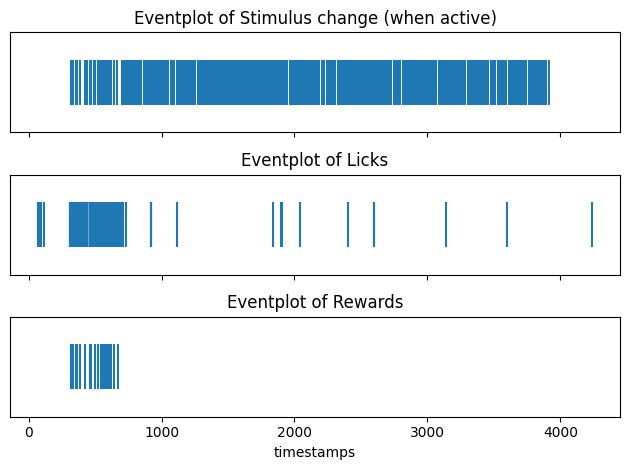

In [43]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].eventplot(stimulus_table[(stimulus_table.is_change) & (stimulus_table.active)].start_time)
ax[1].eventplot(licks.timestamps)
ax[2].eventplot(rewards.timestamps)

ax[2].set_xlabel("timestamps")

ax[0].set_title("Eventplot of Stimulus change (when active)")
ax[1].set_title("Eventplot of Licks")
ax[2].set_title("Eventplot of Rewards");

ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])

plt.tight_layout()

## Let's zoom in

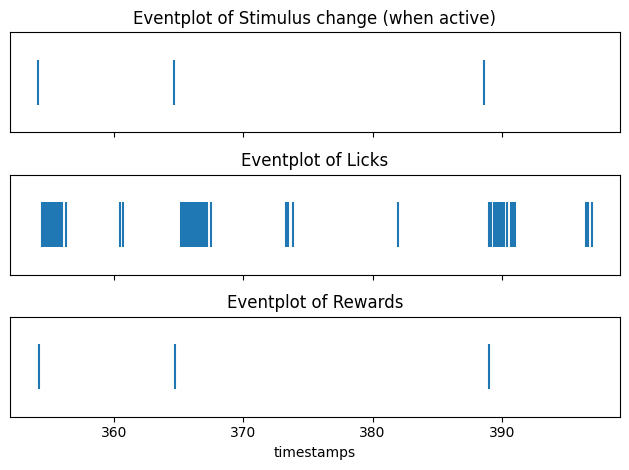

In [44]:
trange = [350, 400]

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].eventplot(
    stimulus_table[(stimulus_table.is_change) & (stimulus_table.active) & (stimulus_table.start_time.between(trange[0], trange[1]))].start_time
)
ax[1].eventplot(licks[licks.timestamps.between(trange[0], trange[1])].timestamps)
ax[2].eventplot(rewards[rewards.timestamps.between(trange[0], trange[1])].timestamps)

ax[2].set_xlabel("timestamps")

ax[0].set_title("Eventplot of Stimulus change (when active)")
ax[1].set_title("Eventplot of Licks")
ax[2].set_title("Eventplot of Rewards");

ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])

plt.tight_layout()

## step 1 : how to identify licking bouts ?

In [45]:
licks["dT"] = licks.timestamps.diff().fillna(0)
licks["is_bout"] = np.where((licks.dT <= 1), True, False)
licks["bout_change"] = np.where(
    ((licks.is_bout) & (licks.is_bout == licks.is_bout.shift())), False, True
)
licks["bout_number"] = licks["bout_change"].cumsum()
licks["bout_number"] = np.where(licks.is_bout, licks.bout_number, 0)

for bout in licks[licks.bout_number != 0].bout_number.unique():
    first_index = licks[licks.bout_number == bout].index[0]
    if first_index == 0:
        continue
    else:
        licks.loc[first_index - 1, "bout_number"] = bout

licks[(licks.timestamps.between(390, 400))]

,timestamps,frame,dT,is_bout,bout_change,bout_number
98,390.06553,22753,0.15015,True,False,28
99,390.19891,22761,0.13338,True,False,28
100,390.36578,22771,0.16687,True,False,28
101,390.69934,22791,0.33356,True,False,28
102,390.83276,22799,0.13342,True,False,28
103,390.98290,22808,0.15014,True,False,28
104,396.50407,23139,5.52117,False,True,30
105,396.65420,23148,0.15013,True,True,30
106,396.98783,23168,0.33363,True,False,30


1 68.90307 68.90307
8 311.11771 311.26783
11 319.32441 320.859
13 328.9823 331.56774
15 338.70691 342.24313
17 345.57918 345.72935
19 354.45306 356.32129
21 360.458 360.70819
23 365.21189 367.54713
25 373.28519 373.86895
28 389.03134 390.9829
30 396.50407 396.98783
33 406.31209 406.56231
37 425.84472 428.53021
39 438.58847 438.82195
41 461.1569 464.44292
43 470.09753 474.78469
45 479.95558 480.60611
47 485.94376 486.11061
49 501.00608 505.4931
52 512.14852 512.44878
54 519.03749 522.95737
56 528.84546 530.66365
59 545.22555 548.67832
61 561.72235 566.34279
63 569.3786 569.99579
65 573.68207 577.20163
67 581.23827 584.62434
69 588.69434 589.19474
71 594.24891 598.20212
73 607.50974 611.04597
75 617.26771 620.25348
78 629.99477 630.79537
81 642.08794 645.35726
84 658.68486 658.86834
86 660.10268 660.36957
88 669.11002 672.12917
90 677.45018 677.61698
92 684.18897 684.35583
95 693.22973 693.42989
99 918.38023 919.53117


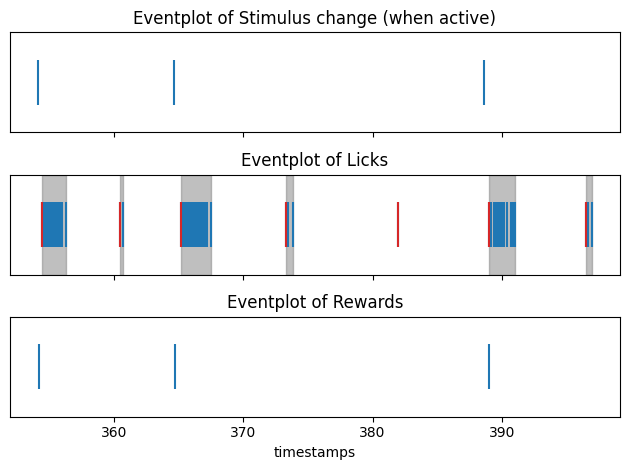

In [46]:
trange = [350, 400]

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].eventplot(
    stimulus_table[(stimulus_table.is_change) & (stimulus_table.active) & (stimulus_table.start_time.between(trange[0], trange[1]))].start_time
)
ax[1].eventplot(licks[licks.timestamps.between(trange[0], trange[1])].timestamps)
ax[1].eventplot(licks[(licks.timestamps.between(trange[0], trange[1])) & (licks.dT >= 1)].timestamps, color="tab:red")
ax[2].eventplot(rewards[rewards.timestamps.between(trange[0], trange[1])].timestamps)

for bout_number in sorted(licks.bout_number.unique())[1:]:
    tmin = licks[licks.bout_number == bout_number].timestamps.min()
    tmax = licks[licks.bout_number == bout_number].timestamps.max()
    print(bout_number, tmin, tmax)
    if (tmin > trange[0]) & (tmax < trange[1]):
        
        ax[1].axvspan(tmin, tmax, color="grey", alpha=0.5)

ax[2].set_xlabel("timestamps")

ax[0].set_title("Eventplot of Stimulus change (when active)")
ax[1].set_title("Eventplot of Licks")
ax[2].set_title("Eventplot of Rewards");

ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])

plt.tight_layout()

In [47]:
lickstarts = licks[licks.dT >= 1].timestamps.values
lickstarts

array([  77.14313,   84.09879,   85.31647,   94.64071,  113.53953,
        311.11771,  314.0534 ,  319.32441,  328.9823 ,  338.70691,
        345.57918,  354.45306,  360.458  ,  365.21189,  373.28519,
        381.94217,  389.03134,  396.50407,  401.99192,  406.31209,
        411.68316,  416.97082,  425.84472,  438.58847,  461.1569 ,
        470.09753,  479.95558,  485.94376,  501.00608,  507.82833,
        512.14852,  519.03749,  528.84546,  540.02127,  545.22555,
        561.72235,  569.3786 ,  573.68207,  581.23827,  588.69434,
        594.24891,  607.50974,  617.26771,  624.15667,  629.99477,
        636.01635,  642.08794,  652.12947,  658.68486,  660.10268,
        669.11002,  677.45018,  684.18897,  688.0088 ,  693.22973,
        713.17933,  733.21233,  918.38023, 1117.62627, 1835.69587,
       1901.09932, 1903.43457, 2038.17787, 2400.89074, 2595.66644,
       2597.96832, 3139.61054, 3600.5369 , 4240.39264])

In [50]:
#### misses

misses = []

for start_time in stimulus_table[
    (stimulus_table.is_change)
    & (stimulus_table.active)
    & (stimulus_table.start_time.between(300, 1000))
].start_time.unique():
    anylick = [l for l in lickstarts if (l >= start_time) & (l <= start_time + 0.75)]
    if len(anylick) == 0:
        misses.append(start_time)
misses = np.array(misses)

#### correct rejections

# crs = []

# for start_time in stimulus_table[
#     (stimulus_table.is_change == False)
#     & (stimulus_table.active)
#     & (stimulus_table.start_time.between(300, 1000))
# ].start_time.unique():
#     # anylick = [l for l in lickstarts if (l >= start_time) & (l <= start_time + 0.75)]
#     # if len(anylick) == 0:
#     counter = 0
#     for bout_number in sorted(licks[licks.timestamps.between(300, 1000)].bout_number.unique())[1:]:
#         tmin = licks[licks.bout_number == bout_number].timestamps.min()
#         tmax = licks[licks.bout_number == bout_number].timestamps.max()
#         if tmin <= start_time <= tmax:
#             counter = 1
#             break
#     if counter == 0:
#         crs.append(start_time)
# crs = np.array(crs)

#### hits

hits = []
for lickstart in lickstarts:
    # print(lickstart)
    stm = stimulus_table[
        (stimulus_table.start_time.between(lickstart - 0.75, lickstart))
        & (stimulus_table.is_change)
    ]
    # print(lickstart, len(stm))

    if len(stm) > 0:
        # hits.append(stm.start_time.item())
        hits.append(lickstart)
hits = np.array(hits)

#### false alarms

false_alarms = []
for lickstart in lickstarts:
    # print(lickstart)
    stm = stimulus_table[
        (stimulus_table.start_time.between(lickstart - 0.75, lickstart))
        & (stimulus_table.is_change)
    ]
    # print(lickstart, len(stm))

    if len(stm) == 0:
        false_alarms.append(lickstart)
false_alarms = np.array(false_alarms)

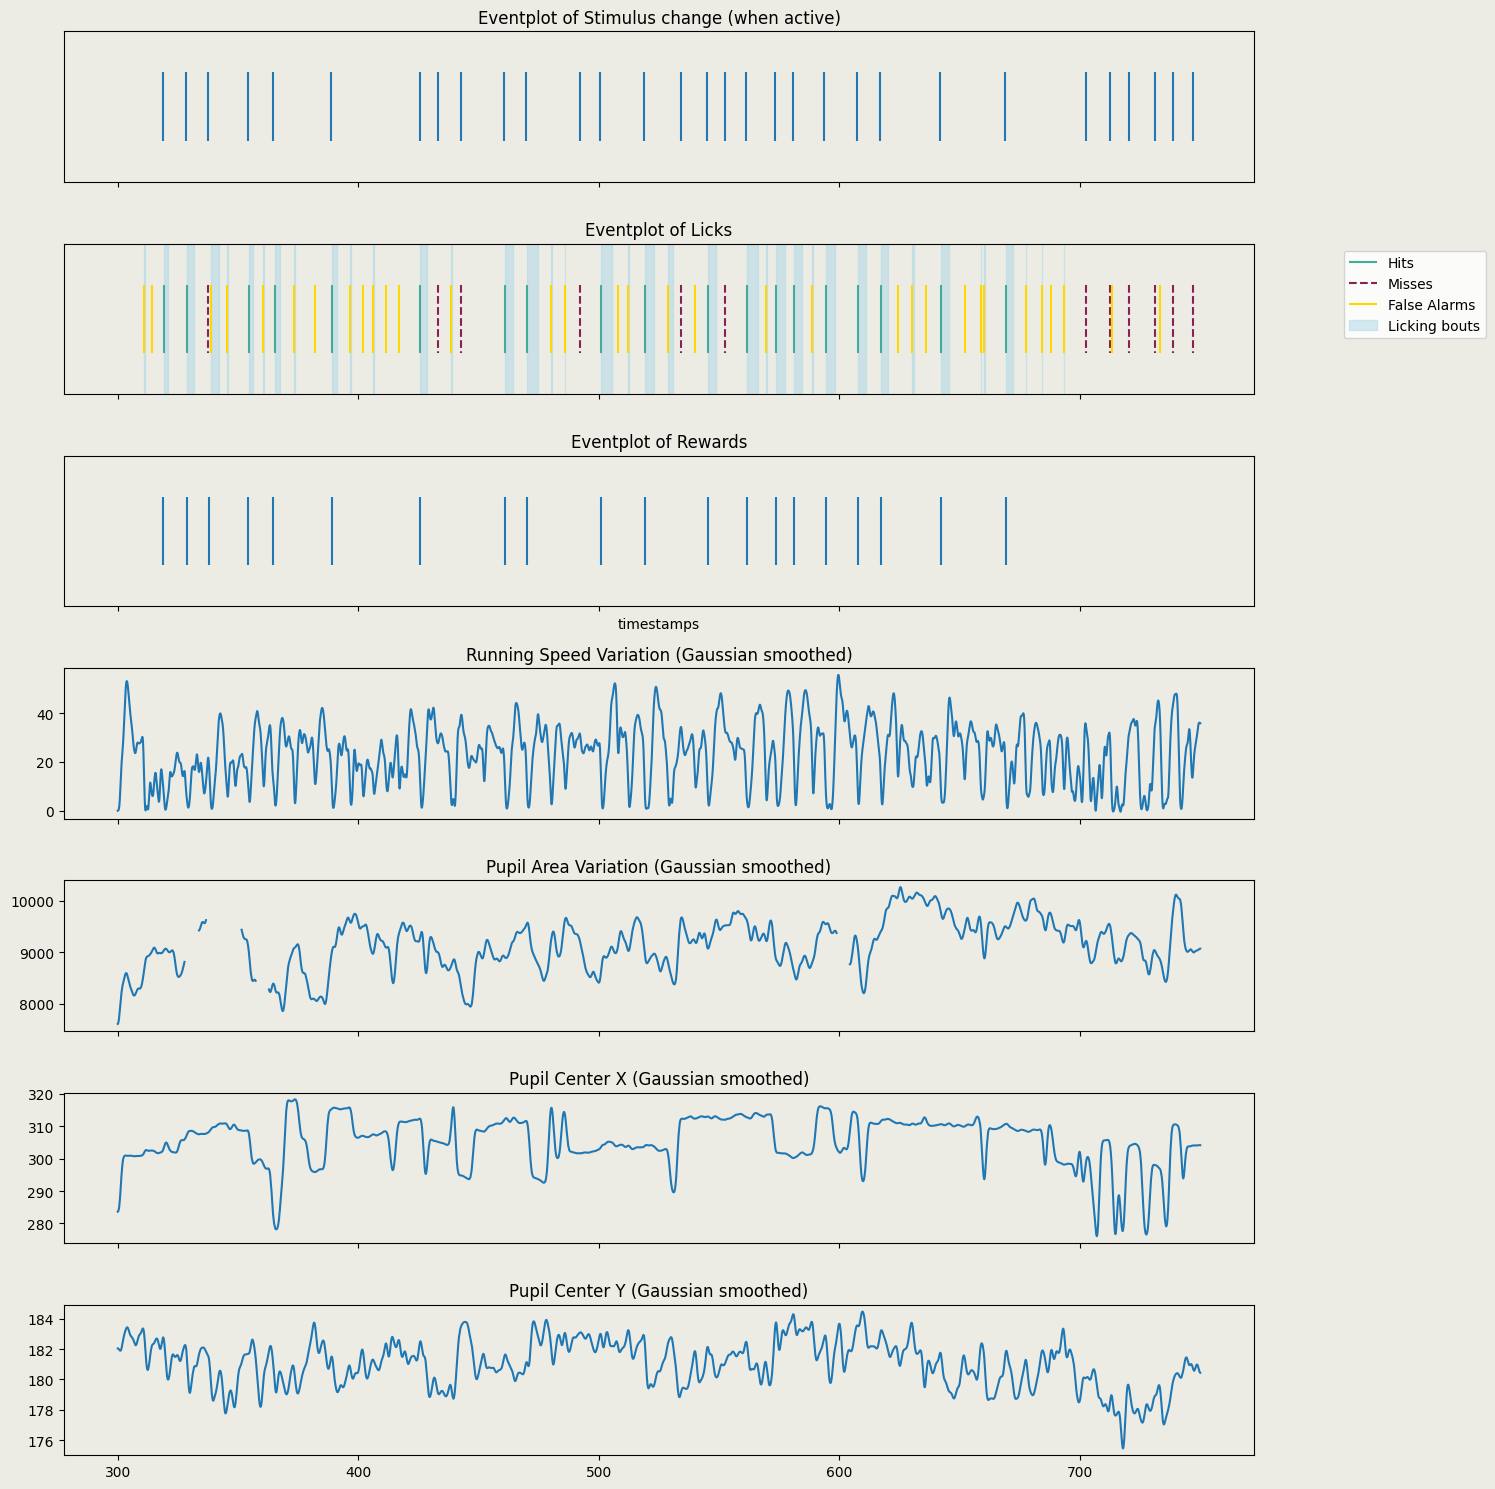

In [67]:
trange = [300, 750]

fig, ax = plt.subplots(nrows=7, ncols=1, sharex=True, figsize=(15, 15))
fig.set_facecolor("#edece4")
for axes in ax:
    axes.set_facecolor("#edece4")

ax[0].eventplot(
    stimulus_table[
        (stimulus_table.is_change)
        & (stimulus_table.active)
        & (stimulus_table.start_time.between(trange[0], trange[1]))
    ].start_time
)
# ax[1].eventplot(licks[licks.timestamps.between(trange[0], trange[1])].timestamps, color="tab:blue", label="All licks")
# ax[1].eventplot(licks[(licks.timestamps.between(trange[0], trange[1])) & (licks.dT >= 1)].timestamps, color="tab:red")
ax[1].eventplot(
    hits[(hits >= trange[0]) & (hits <= trange[1])],
    color="#44AA99",
    label="Hits",
    zorder=5,
)
ax[1].eventplot(
    misses[(misses >= trange[0]) & (misses <= trange[1])],
    color="#882255",
    ls="--",
    label="Misses",
    zorder=5,
)
ax[1].eventplot(
    false_alarms[(false_alarms >= trange[0]) & (false_alarms <= trange[1])],
    color="gold",
    label="False Alarms",
    zorder=5,
)
# ax[1].eventplot(crs[(crs >= trange[0]) & (crs <= trange[1])], color="grey", ls="--", label = "Correct Rejections")
ax[2].eventplot(rewards[rewards.timestamps.between(trange[0], trange[1])].timestamps)

ctr = 0
for bout_number in sorted(licks.bout_number.unique())[1:]:
    tmin = licks[licks.bout_number == bout_number].timestamps.min()
    tmax = licks[licks.bout_number == bout_number].timestamps.max()
    # print(bout_number, tmin, tmax)
    if (tmin > trange[0]) & (tmax < trange[1]):
        if ctr == 0:
            label = "Licking bouts"
            ctr += 1
        else:
            label = ""
        ax[1].axvspan(tmin, tmax, color="lightblue", alpha=0.5, label=label)


ax[2].set_xlabel("timestamps")

ax[0].set_title("Eventplot of Stimulus change (when active)")
ax[1].set_title("Eventplot of Licks")
ax[2].set_title("Eventplot of Rewards")

ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])

ax[1].legend(bbox_to_anchor=(1.2, 1))

ax[3].plot(
    running[running.timestamps.between(trange[0], trange[1])]["timestamps"],
    gaussian_filter1d(running[running.timestamps.between(trange[0], trange[1])]["speed"], sigma=20),
)
ax[3].set_title("Running Speed Variation (Gaussian smoothed)")

ax[4].plot(
    eyetracking[eyetracking.timestamps.between(trange[0], trange[1])]["timestamps"],
    gaussian_filter1d(eyetracking[eyetracking.timestamps.between(trange[0], trange[1])]["pupil_area"], sigma=20),
)
ax[4].set_title("Pupil Area Variation (Gaussian smoothed)")

ax[5].plot(
    eyetracking[eyetracking.timestamps.between(trange[0], trange[1])]["timestamps"],
    gaussian_filter1d(eyetracking[eyetracking.timestamps.between(trange[0], trange[1])]["pupil_center_x"], sigma=20),
)
ax[5].set_title("Pupil Center X (Gaussian smoothed)")

ax[6].plot(
    eyetracking[eyetracking.timestamps.between(trange[0], trange[1])]["timestamps"],
    gaussian_filter1d(eyetracking[eyetracking.timestamps.between(trange[0], trange[1])]["pupil_center_y"], sigma=20),
)
ax[6].set_title("Pupil Center Y (Gaussian smoothed)")





plt.tight_layout()

## Duration of bouts

In [103]:
bouts = licks[licks.bout_number != 0].reset_index(drop=True)

bouts["category"] = np.nan
# bouts["false_alarm"] = 1
bouts["stimulus_presentation_tstamp"] = np.nan
bouts["latency"] = np.nan
bouts["is_change"] = False

for bout in bouts.bout_number.unique():
    print(f"Bout number is {bout}")
    bout_start = bouts[bouts.bout_number == bout].index[0]
    bouts.loc[bout_start, "dT"] = 0
    bouts.loc[bout_start, "is_bout"] = True
    tstamp = bouts.loc[bout_start, "timestamps"]
    if tstamp in hits:
        bouts.loc[bout_start, "category"] = "hit"
    else:
        bouts.loc[bout_start, "category"] = "false_alarm"
    print(f"Bout start timestamp is {tstamp}")
    stm = stimulus_table[
        (stimulus_table.start_time.between(tstamp - 0.75, tstamp))
    ]
    
    if len(stm) == 1:
        print(f"Yes length is {len(stm)}")
        if stm.is_change.item() :
            print(f"Is it a new image ? {stm.is_change.item()}")
            bouts.loc[bout_start, "is_change"] = True 
        else:
            print(f"Is it a new image ? {stm.is_change.item()}")

        print(f"Most recent stimulus presentation time = {stm.start_time.item()}")
        print(f"Latency = {tstamp - stm.start_time.item()}")
        bouts.loc[bout_start, "stimulus_presentation_tstamp"] = stm.start_time.item()
        bouts.loc[bout_start, "latency"] = tstamp - stm.start_time.item()


    print("-------------------------------------------")

bouts.category.ffill(inplace=True)
bouts.head()

Bout number is 1
Bout start timestamp is 68.90307
-------------------------------------------
Bout number is 8
Bout start timestamp is 311.11771
Yes length is 1
Is it a new image ? False
Most recent stimulus presentation time = 310.56978563055065
Latency = 0.5479243694493334
-------------------------------------------
Bout number is 11
Bout start timestamp is 319.32441
Yes length is 1
Is it a new image ? True
Most recent stimulus presentation time = 318.82653563055067
Latency = 0.4978743694493346
-------------------------------------------
Bout number is 13
Bout start timestamp is 328.9823
Yes length is 1
Is it a new image ? True
Most recent stimulus presentation time = 328.5844556305506
Latency = 0.3978443694493876
-------------------------------------------
Bout number is 15
Bout start timestamp is 338.70691
Yes length is 1
Is it a new image ? False
Most recent stimulus presentation time = 338.35914563055064
Latency = 0.34776436944935085
-------------------------------------------
Bo

,timestamps,frame,dT,is_bout,bout_change,bout_number,category,stimulus_presentation_tstamp,latency,is_change
0,68.90307,3499,0.00000,True,True,1,false_alarm,NaN,NaN,False
1,311.11771,18020,0.00000,True,True,8,false_alarm,310.569786,0.547924,False
2,311.26783,18029,0.15012,True,True,8,false_alarm,NaN,NaN,False
3,319.32441,18512,0.00000,True,True,11,hit,318.826536,0.497874,True
4,319.64134,18531,0.31693,True,True,11,hit,NaN,NaN,False


In [104]:
gdf = bouts.groupby(["bout_number", "category"]).agg(dT = ("dT", "sum"), latency = ("latency", "min")).reset_index()
gdf

,bout_number,category,dT,latency
0,1,false_alarm,0.00000,NaN
1,8,false_alarm,0.15012,0.547924
2,11,hit,1.53459,0.497874
3,13,hit,2.58544,0.397844
4,15,false_alarm,3.53622,0.347764
5,17,false_alarm,0.15017,0.464514
6,19,hit,1.86823,0.331034
7,21,false_alarm,0.25019,0.331074
8,23,hit,2.33524,0.581334
9,25,false_alarm,0.58376,0.397854


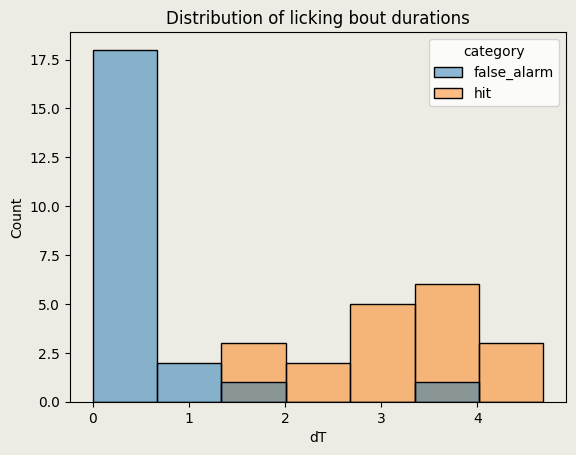

In [85]:
fig,ax = plt.subplots()
fig.set_facecolor("#edece4")
ax.set_facecolor("#edece4")
sns.histplot(data=gdf, x="dT", hue="category", ax=ax);
ax.set_title("Distribution of licking bout durations");

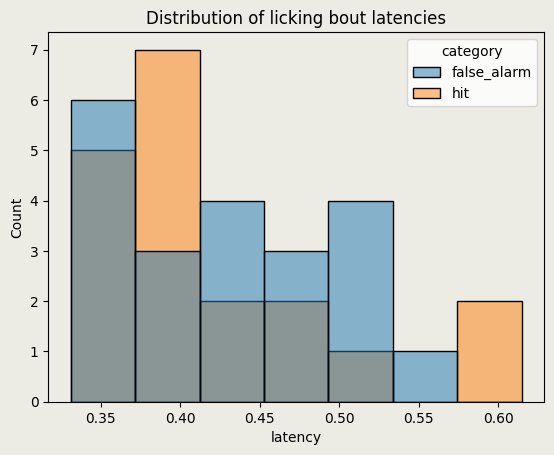

In [105]:
fig,ax = plt.subplots()
fig.set_facecolor("#edece4")
ax.set_facecolor("#edece4")
sns.histplot(data=gdf, x="latency", hue="category", ax=ax);
ax.set_title("Distribution of licking bout latencies");